# **Active Learning-Based Comparative Analysis of Machine Learning Models for Weather Prediction**

# **Introduction**

# In this project, we aim to build and compare two machine learning models- Random Forest Classifier and Logistic Regression for weather prediction. We leverage active learning to iteratively improve model performance by selectively addding the most uncertain samples to the training set.

In [1]:
import torch 
import pandas as pd
from sklearn.metrics import accuracy_score

# **Implementation Overview**

This project follows a structured pipeline for weather forecasting:

- **Dataset Preprocessing**: Loading and cleaning the dataset, handling missing values, and encoding categorical variables.
- **Feature Engineering**: Scaling numerical features and transforming categorical features for model input.
- **Model Training**: Implementing two machine learning models:
           <br> - Random Forest Classifier
  <br> - Logistic Regression
- **Active Learning**: Iteratively updating the training dataset by selecting the most uncertain predictions based on entropy.
- **Model Evaluation**: Analyzing the models using accuracy, precision, recall, F1-score, and confusion matrices.
- **Visualization**: Plotting validation accuracy and confusion matrices to compare model performance.

# Weather Predictor using Random Forest Classifier

In [2]:
from sklearn import ensemble

class WeatherPredictor_rfc():
    def __init__(self):
        super(WeatherPredictor_rfc,self).__init__()
        self.mode=None
        self.dataset_X,self.dataset_y=None,None
        self.unlabeled_pool_X,self.unlabeled_pool_y=None,None

    def fit(self,features,labels):
        self.model=ensemble.RandomForestClassifier(n_estimators=20,warm_start=True)
        self.dataset_X,self.dataset_y,self.unlabeled_pool_X,self.unlabeled_pool_y=self.create_dataset(features,labels)
        return self.train()

    def predict(self,features):
        if features.ndim==1:
            features=features.reshape(1,-1)
        return self.model.predict(features)
        
    def create_dataset(self,X,y):
        dataset_X,unlabeled_X,dataset_y,unlabeled_y=train_test_split(X,y,test_size=0.9,random_state=32)
        return dataset_X,dataset_y,unlabeled_X,unlabeled_y

    def compute_entropy(self,probs):
        return -np.sum(probs*np.log2(probs+1e-10))
        
    def update_dataset(self):
        probs=self.model.predict_proba(self.unlabeled_pool_X)
        uncertainties=np.array([self.compute_entropy(prob) for prob in probs])
        most_uncertain_idx=np.argmax(uncertainties)
        new_sample=self.unlabeled_pool_X[most_uncertain_idx].reshape(1, -1)
        new_label=self.unlabeled_pool_y[most_uncertain_idx]
        self.dataset_X=np.vstack([self.dataset_X,new_sample])
        self.dataset_y=np.append(self.dataset_y,new_label)
        self.unlabeled_pool_X=np.delete(self.unlabeled_pool_X,most_uncertain_idx, axis=0)
        self.unlabeled_pool_y=np.delete(self.unlabeled_pool_y,most_uncertain_idx)
    
    def train(self,epochs=20,add_estimator=5):
        valid_accuracy=[]
        self.model.fit(self.dataset_X,self.dataset_y)
        pred=self.model.predict(self.unlabeled_pool_X)
        accuracy=accuracy_score(y_true=pred,y_pred=self.unlabeled_pool_y)
        valid_accuracy.append(accuracy)
        
        for epoch in range(epochs):
            self.update_dataset()
            self.model.n_estimators+=add_estimator
            self.model.fit(self.dataset_X,self.dataset_y)
            pred=self.model.predict(self.unlabeled_pool_X)
            accuracy=accuracy_score(y_true=self.unlabeled_pool_y,y_pred=pred)
            valid_accuracy.append(accuracy)
        return valid_accuracy

# Weather Predictor using Logistic Regression

In [3]:
from sklearn import linear_model

class WeatherPredictor_lr():
    def __init__(self):
        super(WeatherPredictor_lr,self).__init__()
        self.mode=None
        self.dataset_X,self.dataset_y=None,None
        self.unlabeled_pool_X,self.unlabeled_pool_y=None,None

    def fit(self,features,labels):
        self.model=linear_model.LogisticRegression(max_iter=200,warm_start=True)
        self.dataset_X,self.dataset_y,self.unlabeled_pool_X,self.unlabeled_pool_y=self.create_dataset(features,labels)
        return self.train()

    def predict(self,features):
        if features.ndim==1:
            features=features.reshape(1,-1)
        return self.model.predict(features)
        
    def create_dataset(self,X,y):
        dataset_X,unlabeled_X,dataset_y,unlabeled_y=train_test_split(X,y,test_size=0.9,random_state=32)
        return dataset_X,dataset_y,unlabeled_X,unlabeled_y

    def compute_entropy(self,probs):
        return -np.sum(probs*np.log2(probs+1e-10))
        
    def update_dataset(self):
        probs=self.model.predict_proba(self.unlabeled_pool_X)
        uncertainties=np.array([self.compute_entropy(prob) for prob in probs])
        most_uncertain_idx=np.argmax(uncertainties)
        new_sample=self.unlabeled_pool_X[most_uncertain_idx].reshape(1, -1)
        new_label=self.unlabeled_pool_y[most_uncertain_idx]
        self.dataset_X=np.vstack([self.dataset_X,new_sample])
        self.dataset_y=np.append(self.dataset_y,new_label)
        self.unlabeled_pool_X=np.delete(self.unlabeled_pool_X,most_uncertain_idx, axis=0)
        self.unlabeled_pool_y=np.delete(self.unlabeled_pool_y,most_uncertain_idx)
    
    def train(self,epochs=20,add_estimator=5):
        valid_accuracy=[]
        self.model.fit(self.dataset_X,self.dataset_y)
        pred=self.model.predict(self.unlabeled_pool_X)
        accuracy=accuracy_score(y_true=self.unlabeled_pool_y,y_pred=pred)
        valid_accuracy.append(accuracy)
        
        for epoch in range(epochs):
            self.update_dataset()
            self.model.fit(self.dataset_X,self.dataset_y)
            pred=self.model.predict(self.unlabeled_pool_X)
            accuracy=accuracy_score(y_true=pred,y_pred=self.unlabeled_pool_y)
            valid_accuracy.append(accuracy)
        return valid_accuracy

# Dataset Overview

The dataset used in this project consists of various meteorological parameters such as temperature, humidity, wind speed, and precipitation. The target variable is a binary classification indicating whether it will rain or not.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

dataset=pd.read_csv("/kaggle/input/weather-forecast-dataset/weather_forecast_data.csv")
X=dataset.values[:,:-2]
y=dataset.values[:,-1]

def preprocessing_data(scaler_model,data,typedata=None):
  if typedata=="Train":
    scaler_model=scaler_model.fit(data)
    return scaler_model,scaler_model.transform(data)
  else:
    return scaler_model.transform(data)
      
def get_labels(data):
    encoder=preprocessing.OneHotEncoder(sparse_output=False)
    labels=encoder.fit_transform(data.reshape(-1,1))
    return np.argmax(labels,axis=1).astype(np.int64)
    
X=np.array(X)
y=get_labels(y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=32)

In [5]:
def get_model(modelname):
    if modelname=='RandomForestClassifier':
        model=WeatherPredictor_rfc()
        return model
    if modelname=='LogisticRegression':
        model=WeatherPredictor_lr()
        return model

In [6]:
model=get_model('RandomForestClassifier')
validation_accuracy_rfc=model.fit(X_train,y_train)
pred_rfc=model.predict(X_test)

model=get_model('LogisticRegression')
validation_accuracy_lr=model.fit(X_train,y_train)
pred_lr=model.predict(X_test)

# Analysis and Results

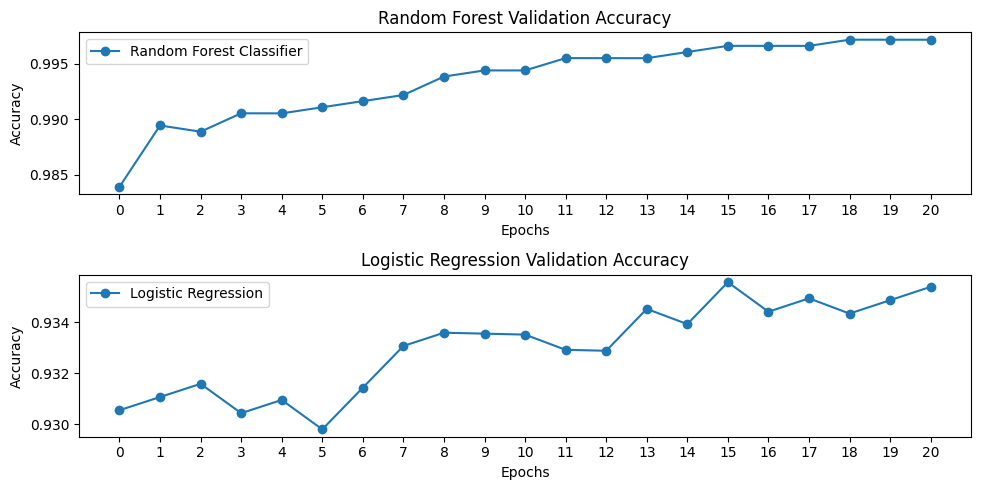

In [7]:
import matplotlib.pyplot as plt

def get_validation_plot(valid_array_rfc,valid_array_lr):
    x=np.arange(len(valid_array_rfc))
    
    fig,axes=plt.subplots(2,1,figsize=(10,5))
    axes[0].plot(x,valid_array_rfc,label="Random Forest Classifier",marker='o')
    axes[0].set_title("Random Forest Validation Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].set_xticks(x)

    axes[1].plot(x,valid_array_lr,label="Logistic Regression",marker='o')
    axes[1].set_title("Logistic Regression Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].set_xticks(x)

    plt.tight_layout()
    plt.show()

get_validation_plot(validation_accuracy_rfc,validation_accuracy_lr)

We trained both models on the dataset using an active learning approach. The validation accuracy improved over multiple epochs as uncertain samples were added to the training data.

# **Model Comparsion**

In [8]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import pandas as pd

def get_metrics_data(truth,prediction):
    accuracy=accuracy_score(y_pred=prediction,y_true=truth)
    precision=precision_score(y_pred=prediction,y_true=truth,average='weighted')
    recall=recall_score(y_pred=prediction,y_true=truth,average='weighted')
    f1_score_value=f1_score(y_pred=prediction,y_true=truth,average='weighted')

    return [accuracy,precision,recall,f1_score_value]
    
def metrics_data(truth,prediction_rfc,prediction_lr):
    
    labels=['Accuracy','Precision','Recall','F1-score']
    metrics_rfc=get_metrics_data(truth,prediction_rfc)
    metrics_lr=get_metrics_data(truth,prediction_lr)
    dic={
        'Metrics':labels,
        'Random Forest Classifier':metrics_rfc,
        'Logistic Regression':metrics_lr
    }
    data=pd.DataFrame(dic).set_index('Metrics')
    return data

metrics=metrics_data(y_test,pred_rfc,pred_lr)
metrics

,Random Forest Classifier,Logistic Regression
Metrics,,
Accuracy,0.994000,0.924000
Precision,0.994042,0.920993
Recall,0.994000,0.924000
F1-score,0.993952,0.921842


**Random Forest Classifier**: Performed better in capturing complex relationships in the dataset, yielding higher accuracy and recall.<br>
**Logistic Regression**: Provided a simpler, interpretable model but had lower accuracy compared to Random Forest.

# **Confusion Matrix**

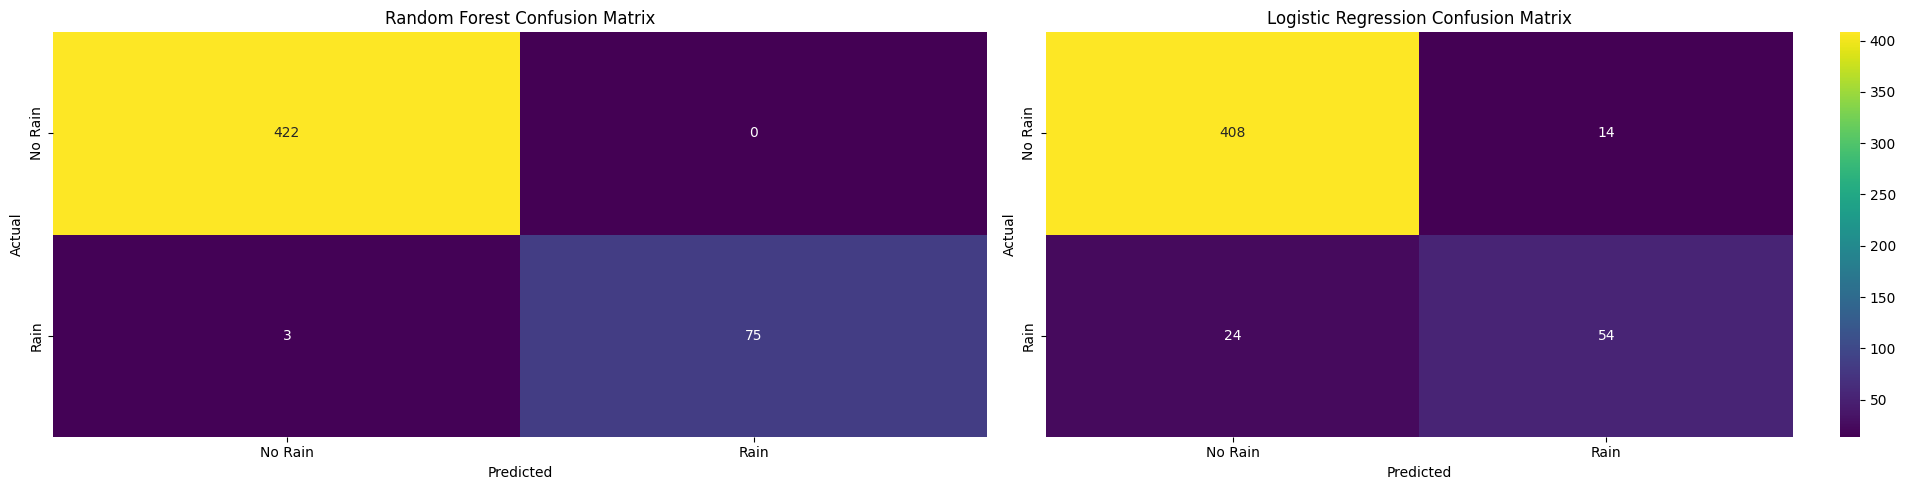

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(truth,prediction_rfc,prediction_lr,class_names):
    fig,axes=plt.subplots(1,2,figsize=(20,5))
    
    cm_rfc=confusion_matrix(truth,prediction_rfc)
    sns.heatmap(cm_rfc,annot=True,fmt='d',cmap='viridis',xticklabels=class_names,yticklabels=class_names,ax=axes[0],cbar=False)
    axes[0].set_title("Random Forest Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    cm_lr=confusion_matrix(truth,prediction_lr)
    sns.heatmap(cm_lr,annot=True,fmt='d',cmap='viridis',xticklabels=class_names,yticklabels=class_names,ax=axes[1])
    axes[1].set_title("Logistic Regression Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test,pred_rfc,pred_lr,class_names=['No Rain','Rain'])

We visualized the confusion matrices for both models to understand misclassification patterns. The Random Forest model had fewer false negatives, indicating better detection of rainy days.

# **Conclusion**
Based on the evaluation metrics, the Random Forest Classifier is the better model for weather forecasting, as it achieved higher accuracy and recall. The use of Active Learning significantly improved model performance by dynamically selecting the most informative training samples. This approach ensures better generalization, especially for uncertain cases.